# Ocean transports and maps

Ocean transport is represented as a vector field defined over the Global Ocean. These case be integrated along a grid path to compute transports between any two points. 

For more about how these methods, please refer to **Forget et al, 2015.** ECCO version 4: An integrated framework for non-linear inverse modeling and global ocean state estimation. https://doi.org/10.5194/gmd-8-3071-2015

Key functions:
- `LatitudeCircles` computes integration paths that follow latitude circles
- `ThroughFlow` computes transports through these integration paths

In [1]:
using MeshArrays, Plots, Statistics
include(joinpath(dirname(pathof(MeshArrays)),"Plots.jl"))

using Pkg; Pkg.add("FortranFiles"); using FortranFiles
include("prepare_transports.jl")

cbp="https://github.com/gaelforget/CbiomesProcessing.jl"
using Pkg; Pkg.add(PackageSpec(url=cbp))
using CbiomesProcessing

if !isdir("GRID_LLC90") 
    run(`git clone https://github.com/gaelforget/GRID_LLC90`)
end

mygrid=GridSpec("LLC90");
GridVariables=GridLoad(mygrid);

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
  Updating git-repo `https://github.com/gaelforget/CbiomesProcessing.jl`
 Resolving package versions...
  Updating `~/mywork/projects_major/2019-jlpkgs/JuliaCon2018Notebooks/Project.toml`
 [no changes]
  Updating `~/mywork/projects_major/2019-jlpkgs/JuliaCon2018Notebooks/Manifest.toml`
 [no changes]


┌ Info: Recompiling stale cache file /Users/gforget/.julia/compiled/v1.1/CbiomesProcessing/C0PiU.ji for CbiomesProcessing [c98f7216-5713-11e9-18a6-f5cd6f6a6fff]
└ @ Base loading.jl:1184


### Time average and vertically integrate transports

_Note: these intermediate results have pre-computed for you._

In [2]:
#using Pkg; Pkg.add("FortranFiles"); using FortranFiles
#!isdir("nctiles_climatology") ? error("missing files") : nothing
#include(joinpath(dirname(pathof(MeshArrays)),"gcmfaces_nctiles.jl"))
#(TrspX, TrspY, TauX, TauY, SSH)=trsp_prep(mygrid,GridVariables,"GRID_LLC90/");

Let's read the intermediate results from file using `trsp_read`.

In [3]:
(TrspX, TrspY, TauX, TauY, SSH)=trsp_read(mygrid,"GRID_LLC90/");

Alternatively these can be recomputed from three-dimensional time-varying velocity fields via `trsp_prep`.

### Transports between latitude bands

In [4]:
UVmean=Dict("U"=>TrspX,"V"=>TrspY,"dimensions"=>["x","y"]);
LC=LatitudeCircles(-89.0:89.0,GridVariables);

T=Array{Float64,1}(undef,length(LC));
for i=1:length(LC)
   T[i]=ThroughFlow(UVmean,LC[i],GridVariables)
end

### Plot result

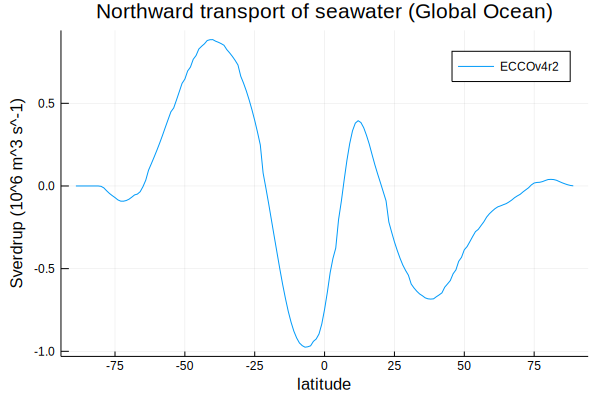

In [5]:
lat=-89.0:89.0
plot(lat,T/1e6,xlabel="latitude",ylabel="Sverdrup (10^6 m^3 s^-1)",
    label="ECCOv4r2",title="Northward transport of seawater (Global Ocean)")

### Plot transport maps

_Note that vector field orientations differ amongst the arrays._

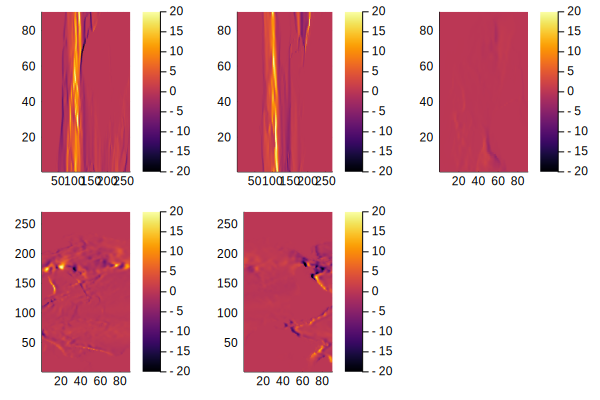

In [6]:
heatmap(1e-6*TrspX,clims=(-20.0,20.0))
#heatmap(1e-6*TrspY,clims=(-20.0,20.0))

Convert to `Sv` and mask out land

In [7]:
u=1e-6 .*UVmean["U"]; v=1e-6 .*UVmean["V"];
u[findall(GridVariables["hFacW"][:,1].==0)].=NaN;
v[findall(GridVariables["hFacS"][:,1].==0)].=NaN;

`x/y` transport at cell center

In [8]:
using Statistics
nanmean(x) = mean(filter(!isnan,x))
nanmean(x,y) = mapslices(nanmean,x,dims=y)

(u,v)=exch_UV(u,v);
uC=similar(u); vC=similar(v);
for iF=1:mygrid.nFaces;
    tmp1=u[iF][1:end-1,:]; tmp2=u[iF][2:end,:];
    uC[iF]=reshape(nanmean([tmp1[:] tmp2[:]],2),size(tmp1));
    tmp1=v[iF][:,1:end-1]; tmp2=v[iF][:,2:end];
    vC[iF]=reshape(nanmean([tmp1[:] tmp2[:]],2),size(tmp1));
end

`Eastward/Northward` transport

_Note: compare vector field orientations with previous plot._

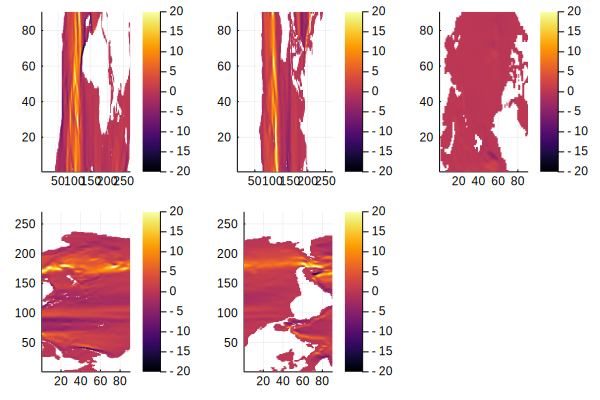

In [9]:
cs=GridVariables["AngleCS"];
sn=GridVariables["AngleSN"];
u=uC.*cs-vC.*sn;
v=uC.*sn+vC.*cs;
heatmap(u,clims=(-20.0,20.0))

Transport as a function of longitude and latitude

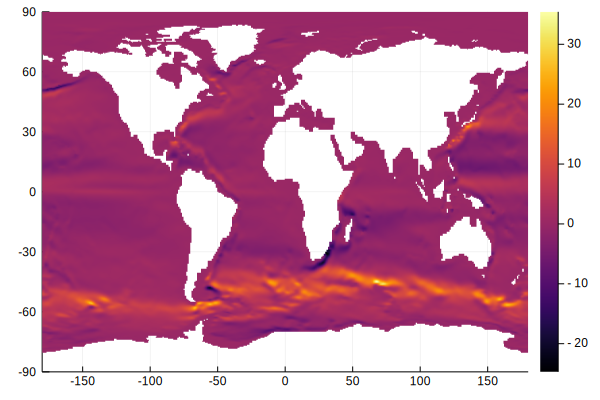

In [10]:
SPM,lon,lat=CbiomesProcessing.read_SPM("GRID_LLC90/")
uI=CbiomesProcessing.MatrixInterp(write(u),SPM,size(lon))
heatmap(vec(lon[:,1]),vec(lat[1,:]),transpose(uI))